Note that the in

# Urban footprinter: a convolution-based approach to extract urban extents from LULC rasters

Administrative boundaries are often defined manually case-by-case and based on subjective judgement. As a consequence, their widespread use in the context of urban and enviornmental studies can lead to misleading outcomes [1, 2].

The aim of the urban footprinter package is to provide a repeatable convolution-based method to extract the extent of the urban regions.

The study area for this example is a rasterized extract of [the official cadastral survey of the Canton of Zurich, Switzerland](https://are.zh.ch/internet/baudirektion/are/de/geoinformation/Themen/amtliche_vermessung.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from matplotlib import cm, colors
from scipy import ndimage as ndi

import urban_footprinter as ufp

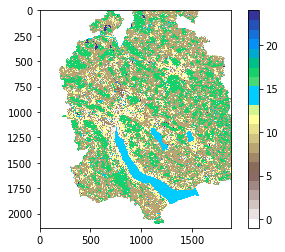

In [2]:
raster_filepath = 'data/zurich.tif'

with rio.open(raster_filepath) as src:
    lulc_arr = src.read(1)
    res = src.res[0]  # only square pixels are supported
    # custom colormap to plot the raster
    # https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
    num_classes = len(np.unique(lulc_arr))
    terrain_r_cmap = cm.get_cmap('terrain_r', num_classes)
    color_values = terrain_r_cmap(np.linspace(0, 1, num_classes))
    blue = np.array([0, .8, 1, 1])
    color_values[13, :] = blue  # water
    color_values[14, :] = blue  # water
    cmap = colors.ListedColormap(color_values)
    # np.where is used because nodata values of 255 would distort the colormap
    plt.imshow(np.where(lulc_arr != 255, lulc_arr, -1), cmap=cmap)
    plt.colorbar()

According to the land cover classification of the dataset, the codes 0 to 7 correspond to urban land cover classes. Therefore, the array of urban/non-urban pixels looks as follows:

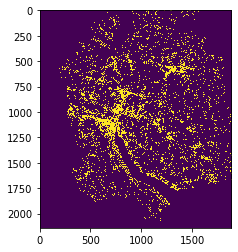

In [3]:
urban_lulc_classes = range(8)
urban_lulc_arr = np.isin(lulc_arr, urban_lulc_classes).astype(np.uint32)
plt.imshow(urban_lulc_arr)

## How the urban footprinter works

The approach of the urban footprinter library is built upon the methods used in the "Atlas of Urban Expansion" by Angel et al. [3]. The main idea is that a pixel is considered part of the urban extent depending on the proportion of built-up pixels that surround it. Accordingly, the extraction of the urban extent can be customized by means of the following three parameters:

* `kernel_radius`: radius (in meters) of the circular kernel used in the convolution
* `urban_threshold`: proportion of neighboring (within the kernel) urban pixels after which a given pixel is considered urban
* `buffer_dist` (optional): buffer distance (in meters) to add around the computed mask

### Convolution with a circular kernel

The main task consists in computing, for each pixel of the raster, the proportion of surrounding build-up pixels. This is done by means of a convolution with a circular kernel. In this example, the `kernel_radius` parameter will be set to 500 meters.

In [4]:
kernel_radius = 500

In [5]:
kernel_pixel_radius = int(kernel_radius // res)
kernel_pixel_len = 2 * kernel_pixel_radius + 1

y, x = np.ogrid[-kernel_pixel_radius:kernel_pixel_len -
                kernel_pixel_radius, -kernel_pixel_radius:
                kernel_pixel_len - kernel_pixel_radius]
mask = x * x + y * y <= kernel_pixel_radius * kernel_pixel_radius

kernel = np.zeros((kernel_pixel_len, kernel_pixel_len), dtype=np.uint32)
kernel[mask] = 1


The kernel will be an array of ones (the circle) and zeros which looks as follows:

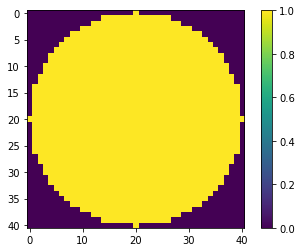

In [6]:
plt.imshow(kernel)
plt.colorbar()

The convolution is computed by means of the [convolve](https://docs.scipy.org/doc/scipy-0.16.0/reference/ndimage.html) function of SciPy.

In [7]:
conv_result = ndi.convolve(urban_lulc_arr, kernel)

Since both `urban_lulc_arr` and `kernel` are arrays of ones and zeros, the result corresponds to the number of built-up pixels that lie within a 500m distance.

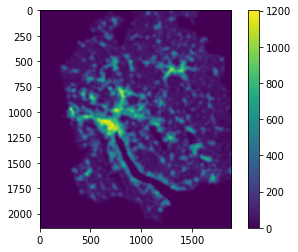

In [8]:
plt.imshow(conv_result)
plt.colorbar()

### Filtering the convolution results

The result of the convolution is then used to classify pixels that are part of the urban extent. To this end, the `urban_threshold` parameter sets the proportion of surrounding built-up pixels after which a pixel is to be considered part of the urban extent. In this example, it will be set to 0.25 (i.e., 25%).

In [9]:
urban_threshold = 0.25

In [10]:
urban_mask = conv_result >= urban_threshold * np.sum(kernel)

The result looks as follows:

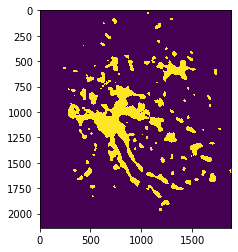

In [11]:
plt.imshow(urban_mask)

### Optional: extract only the largest urban cluster

The fact that raster images are rectangular and real-world cities are not often entails that the raster includes more than just one urban settlement. In such case, the user might be interested in the extent that corresponds to the main urban settlement, namely, the largest urban patch of the raster. The largest urban cluster of the resulting `urban_mask` can be obtained by means of the [label](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html#scipy.ndimage.measurements.label) function of SciPy, which performs a connected-component labeling of the input array (i.e., `urban_mask`).

In [12]:
kernel_moore = ndi.generate_binary_structure(2, 2)
label_arr = ndi.label(urban_mask, kernel_moore)[0]
cluster_label = np.argmax(np.unique(label_arr, return_counts=True)[1][1:]) + 1
urban_mask = (label_arr == cluster_label).astype(np.uint8)

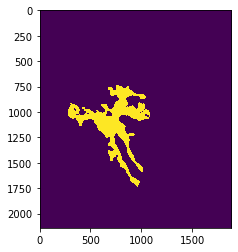

In [13]:
plt.imshow(urban_mask)

### Optional: adding a buffer around the mask

In some contexts, e.g., the study of the urban-rural gradient in landscape ecology, it might be of interest to add a buffer around the urban extent. In this example, a buffer of 1000 meters will be added to the extracted urban extent.

In [14]:
buffer_dist = 1000

To this end, the [binary_dilation](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.morphology.binary_dilation.html#scipy.ndimage.morphology.binary_dilation) function of Scipy can be used as follows:

In [15]:
iterations = int(buffer_dist // res)
kernel_moore = ndi.generate_binary_structure(2, 2)
urban_mask = ndi.binary_dilation(urban_mask, kernel_moore, iterations=iterations)

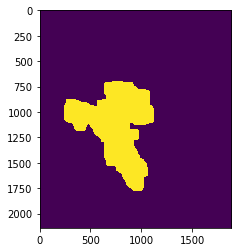

In [16]:
plt.imshow(urban_mask)

## The urban footprinter API

The urban footprinter package provides two ways to execute the procedure described above. On the one hand, an *object-oriented* interface which is well suited for the interactive exploration with different parameter values. On the other hand, the whole procedure is also encapsulated into a single function.

### Object-oriented approach

The `UrbanFootprinter` class can instantiated as follows:

In [17]:
help(ufp.UrbanFootprinter.__init__)

Help on function __init__ in module urban_footprinter:

__init__(self, raster, urban_classes, res=None)
    Parameters
    ----------
    raster : ndarray or str, file object or pathlib.Path object
        Land use/land cover (LULC) raster. If passing a ndarray (instead
        of the path to a geotiff), the resolution (in meters) must be
        passed to the `res` keyword argument.
    urban_classes : int or list-like, optional
        Code or codes of the LULC classes that must be considered urban.
        Not needed if `raster` is already a boolean array of
        urban/non-urban LULC classes.
    res : numeric, optional
        Resolution of the `raster` (assumes square pixels). Ignored if
        `raster` is a path to a geotiff.



In [18]:
urban_classes = list(range(8))

uf = ufp.UrbanFootprinter(raster_filepath, urban_classes=urban_classes)

Then, given the `compute_footprint_mask` will compute the urban extent mask according to the provided `kernel_radius`, `urban_threshold`, and optionally `largest_patch_only` and `buffer_dist` arguments:

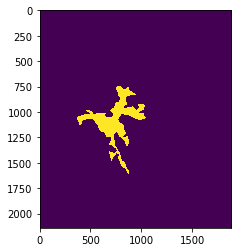

In [19]:
kernel_radius = 500
urban_threshold = 0.25

urban_mask = uf.compute_footprint_mask(kernel_radius, urban_threshold)
plt.imshow(urban_mask)

Note that the execution of `compute_footprint_mask` takes some time, since it is when the convolution (the most expensive task of the workflow) is executed. The main advantage of using the `UrbanFootprinter` class, is that the convolution results are cached, so that further calls avoid performing it if it is not necessary. For instance, imagine that we wanted to set `urban_threshold` to 10%. The call to `compute_footprint_mask` below will compute the urban mask accordingly *without having to perform the convolution again*:

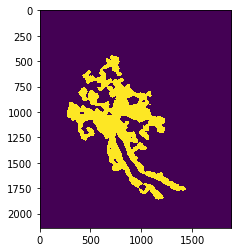

In [20]:
urban_threshold = 0.10

urban_mask = uf.compute_footprint_mask(kernel_radius, urban_threshold)
plt.imshow(urban_mask)

The same applies if we wanted to add a buffer around the mask:

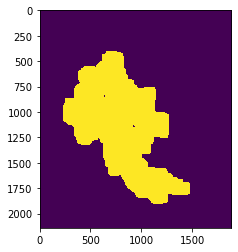

In [21]:
urban_mask = uf.compute_footprint_mask(kernel_radius, urban_threshold,
                                       buffer_dist=1000)
plt.imshow(urban_mask)

Nevertheless, note that if we wanted to change the radius of the convolution kernel, a new (different) convolution operation would have to be performed.

Finally, the urban extent can also be obtained as a vector geometry (instead of a raster array) by means of the `compute_footprint_mask_shp` method:

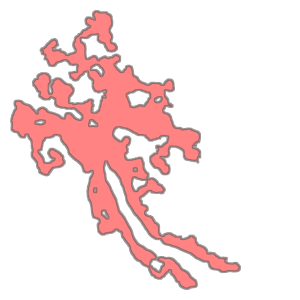

In [22]:
urban_mask = uf.compute_footprint_mask_shp(kernel_radius, urban_threshold)
urban_mask

### Single function approach

If interactive exploration of the parameters is not required, the whole procedure described above can be executed with the single function named `urban_footprint_mask`, which accepts the following arguments:

In [23]:
help(ufp.urban_footprint_mask)

Help on function urban_footprint_mask in module urban_footprinter:

urban_footprint_mask(raster, kernel_radius, urban_threshold, urban_classes=None, largest_patch_only=True, buffer_dist=None, res=None)
    Computes a boolean mask of the urban footprint of a given raster.
    
    Parameters
    ----------
    raster : ndarray or str, file object or pathlib.Path object
        Land use/land cover (LULC) raster. If passing a ndarray (instead of the
        path to a geotiff), the resolution (in meters) must be passed to the
        `res` keyword argument.
    kernel_radius : numeric
        The radius (in meters) of the circular kernel used in the convolution.
    urban_threshold : float from 0 to 1
        Proportion of neighboring (within the kernel) urban pixels after which
        a given pixel is considered urban.
    urban_classes : int or list-like, optional
        Code or codes of the LULC classes that must be considered urban. Not
        needed if `raster` is already a boolean

Therefore, the urban extent extracted above can be obtained as in:

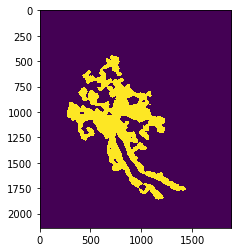

In [24]:
urban_mask = ufp.urban_footprint_mask(
    raster_filepath, kernel_radius, urban_threshold, urban_classes=urban_classes)
plt.imshow(urban_mask)

Like in the object-oriented approach, the urban extent can also be obtained as a vector geometry (instead of a raster array) by means of the `urban_footprint_mask_shp` function:

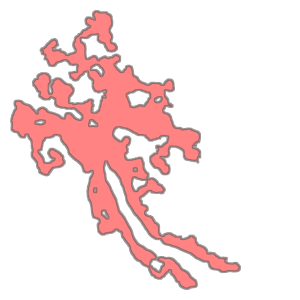

In [25]:
urban_mask = ufp.urban_footprint_mask_shp(
    raster_filepath, kernel_radius, urban_threshold, urban_classes=urban_classes)
urban_mask

## References

1. Oliveira, E. A., Andrade Jr, J. S., & Makse, H. A. (2014). Large cities are less green. Scientific reports, 4, 4235.
2. Rozenfeld, H. D., Rybski, D., Andrade, J. S., Batty, M., Stanley, H. E., & Makse, H. A. (2008). Laws of population growth. Proceedings of the National Academy of Sciences, 105(48), 18702-18707.
3. Angel, S., Blei, A. M., Civco, D. L., & Parent, J. (2016). Atlas of urban expansion - The 2016 edition, Volume 1: Areas and Densities. New York: New York University, Nairobi: UN-Habitat, and Cambridge, MA: Lincoln Institute of Land Policy.